In [2]:
%load_ext autoreload
%autoreload 2

# SETUP

In [2]:
import sys
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
import torch
#import torch.nn as nn # basic building blocks of neural networks
import torchvision.transforms.functional as TF
import torchvision.transforms as T
from IPython.display import HTML, display
from matplotlib import pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from tqdm import tqdm

from sklearn.metrics import confusion_matrix # for evaluating the model of a single pixel basis

from max import locate_data, load_data
from bence import compare_images, augment_images_plain,augment_five_crop
#from bence import augment_perspective for some reason I am not able to import this function

pd.set_option("display.max_columns", None)

assert sys.version_info >= (
    3,
    10,
), "This notebook requires at least Python 3.10"

# DATA LOADING

In [3]:
def augment_perspective(X_tensor,y_tensor,distortions_scale= 0.6,p = 1.0, no_augmentations = 2):

    perspective = T.RandomPerspective(distortion_scale=distortions_scale, p=1.0)
    samples = np.random.randint(X_tensor.shape[0], size = no_augmentations)
    joint_tensor = torch.cat(
        (X_tensor.permute(0,3,1,2)[samples],y_tensor.permute(0,3,1,2)[samples]),0)
    X = perspective(joint_tensor)
    X_changes = X[:no_augmentations]
    y_changes = X[no_augmentations:]
    
    return X_changes , y_changes

In [4]:
DATA_DIR = Path("../data/CamVid/")

img_height = 720
img_width = 960

In [5]:
class_lables, X_train_paths, y_train_paths, X_test_paths, y_test_paths, X_val_paths, y_val_paths = locate_data(DATA_DIR)

class_lables.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
name,Animal,Archway,Bicyclist,Bridge,Building,Car,CartLuggagePram,Child,Column_Pole,Fence,LaneMkgsDriv,LaneMkgsNonDriv,Misc_Text,MotorcycleScooter,OtherMoving,ParkingBlock,Pedestrian,Road,RoadShoulder,Sidewalk,SignSymbol,Sky,SUVPickupTruck,TrafficCone,TrafficLight,Train,Tree,Truck_Bus,Tunnel,VegetationMisc,Void,Wall
r,64,192,0,0,128,64,64,192,192,64,128,192,128,192,128,64,64,128,128,0,192,128,64,0,0,192,128,192,64,192,0,64
g,128,0,128,128,0,0,0,128,192,64,0,0,128,0,64,192,64,64,128,0,128,128,128,0,64,64,128,128,0,192,0,192
b,64,128,192,64,0,128,192,64,128,128,192,64,64,192,64,128,0,128,192,192,128,128,192,64,64,128,0,192,64,0,0,0


In [6]:
# Load data into memory
X_train = load_data(X_train_paths)
y_train = load_data(y_train_paths)

assert (
    type(X_train[0][0][0][0]) == np.uint8
), "image is not stored as unit8 dtype"  # PyTorch likes uint8

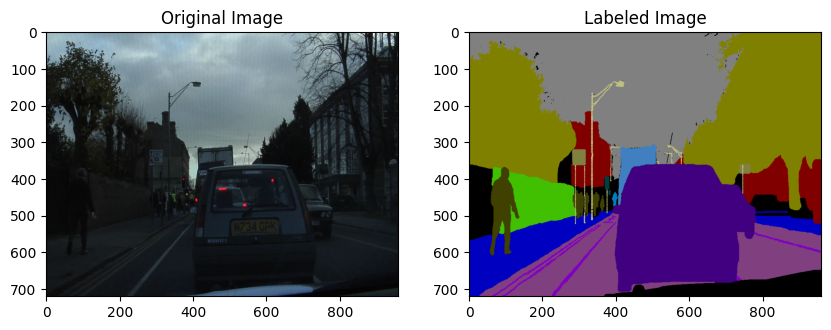

In [7]:
# Show a sample image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
img_idx = 0
ax1.set_title("Original Image")
ax1.imshow(X_train[img_idx])

ax2.set_title("Labeled Image")
ax2.imshow(y_train[img_idx])
plt.show()

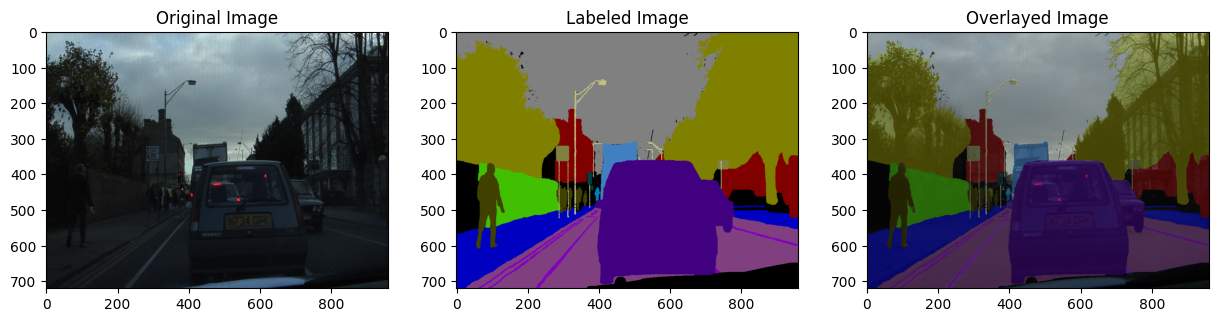

In [8]:
# Show a sample image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
img_idx = 0
ax1.set_title("Original Image")
ax1.imshow(X_train[img_idx])

ax2.set_title("Labeled Image")
ax2.imshow(y_train[img_idx])


#images on top of echouther

ax3.set_title("Overlayed Image")
ax3.imshow(X_train[img_idx])
ax3.imshow(y_train[img_idx], alpha=0.5)

plt.show()

In [9]:
# Prep data for pytorch
training_batch_size = 20

train_loader = DataLoader(dataset=X_train, batch_size=training_batch_size)

# MODEL DEV

Intersection over Union (IoU) -> commonly used evaluation metric for supervised semantic image segmentation tasks.

In [10]:
SMOOTH = 1e-6 # To avoid division by zero

def iou(model_output: torch.Tensor, label: torch.Tensor) -> float:
    """Calculate the IoU for a single model output and label pair."""
    intersection = (
        (model_output & label).float().sum((1, 2))
    )  # Will be zero if Truth=0 or Prediction=0
    union = (model_output | label).float().sum((1, 2))  # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # smooth division to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.7), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch


def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W

    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.7), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

In [11]:
def compare_images(images,image_titles = ""):
    
    if image_titles == "":
        image_titles = tuple([f'Image {i}' for i in range(len(images))])

    no_images = len(images)
    fig, axs = plt.subplots(1, no_images, figsize=(5*no_images, 5))
    for i,ax in enumerate(axs):

        ax.set_title(image_titles[i])
        ax.imshow(images[i])

    plt.show()
    

In [12]:
print(type(y_train))
print(y_train.shape)

<class 'numpy.ndarray'>
(369, 720, 960, 3)


In [13]:
y_train_tensor = torch.from_numpy(y_train)
X_train_tensor = torch.from_numpy(X_train)

#append flipped images alog axis 2

X_train_tensor = torch.cat((X_train_tensor, torch.flip(X_train_tensor, [2])), 0)
y_train_tensor = torch.cat((y_train_tensor, torch.flip(y_train_tensor, [2])), 0)

print(X_train_tensor.shape)


org_size = X_train_tensor.shape[0]
org_X = X_train_tensor

torch.Size([738, 720, 960, 3])


In [14]:
# a random hue to all images

for i in range(2):
    # with jitter the kernel crashes on my computer
    jitter = T.ColorJitter(brightness=(1,2),hue=(-0.2,0.5))
    X_train_recolored, y_train_recolored = augment_images_plain(org_X,y_train_tensor,jitter, no_augmentations = 3)
    X_train_tensor = torch.cat((X_train_tensor, X_train_recolored), 0)
    y_train_tensor = torch.cat((y_train_tensor, y_train_recolored ), 0)



In [15]:
org_X.shape[0]

738

In [16]:
X,y =augment_five_crop(org_X,y_train_tensor, no_augmentations = 3)

X_train_tensor = torch.cat((X_train_tensor, X), 0)
y_train_tensor = torch.cat((y_train_tensor, y), 0)


/home/bence/.cache/pypoetry/virtualenvs/image-segmentation-QN7uw8Fi-py3.10/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [17]:
X,y = augment_perspective(org_X,y_train_tensor, no_augmentations = 3)

X_train_tensor = torch.cat((X_train_tensor, X), 0)
y_train_tensor = torch.cat((y_train_tensor, y), 0)

(360, 480)

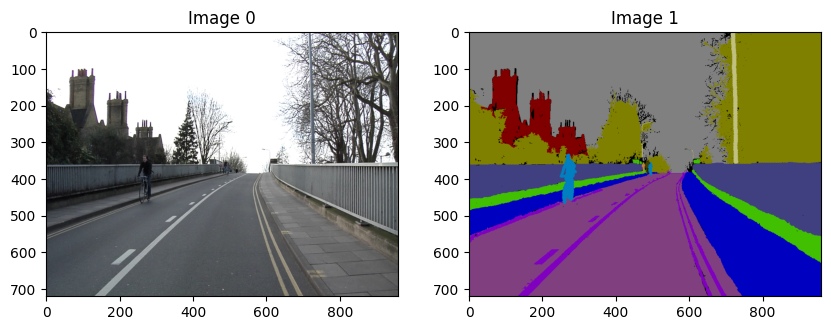

In [24]:
image_num = -55
images = [X_train_tensor[image_num].numpy(),y_train_tensor[image_num].numpy()]
compare_images(images)

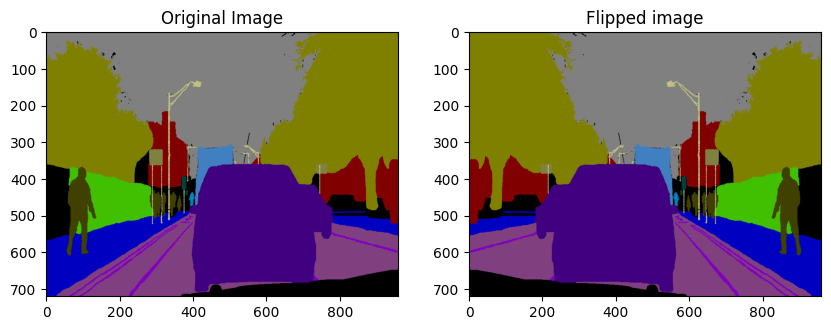

In [ ]:
# check if fliped images are correct

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
img_idx = 0
ax1.set_title("Original Image")
ax1.imshow(y_train[img_idx])

ax2.set_title("Flipped image")
ax2.imshow(y_train_tensor[img_idx+369].numpy())
plt.show()

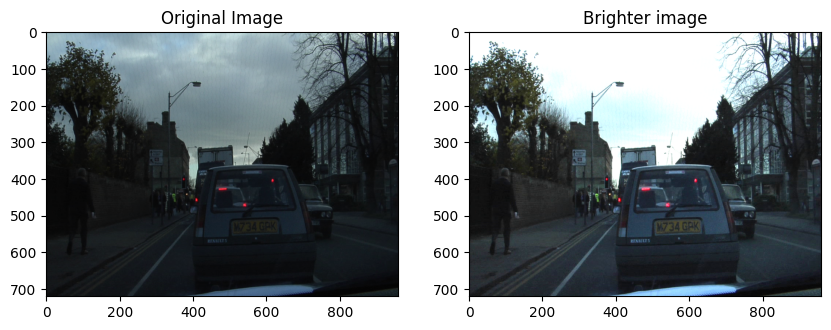

In [ ]:
# adjust brightness on X_train_tensor[0]

brigthter_image = TF.adjust_brightness(X_train_tensor[0].permute(2,0,1), 2)
brigthter_image = brigthter_image.permute(1,2,0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
img_idx = 0
ax1.set_title("Original Image")
ax1.imshow(X_train[img_idx])

ax2.set_title("Brighter image")
ax2.imshow(brigthter_image.numpy())
plt.show()

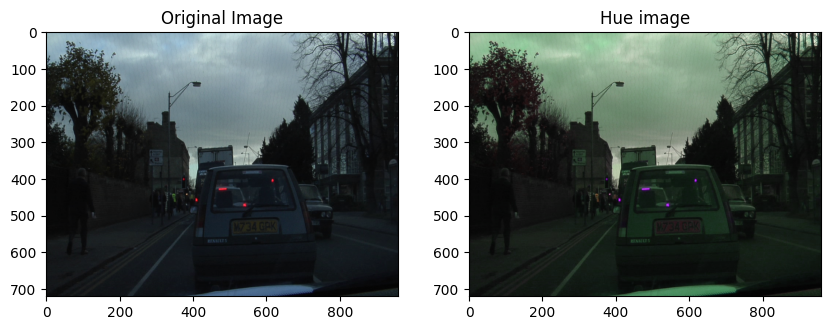

In [ ]:
# adjust hue of the image

hue_image = TF.adjust_hue(X_train_tensor[0].permute(2,0,1), -0.2)
hue_image = hue_image.permute(1,2,0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
img_idx = 0
ax1.set_title("Original Image")
ax1.imshow(X_train[img_idx])

ax2.set_title("Hue image")
ax2.imshow(hue_image.numpy())
plt.show()

/home/bence/.cache/pypoetry/virtualenvs/image-segmentation-QN7uw8Fi-py3.10/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


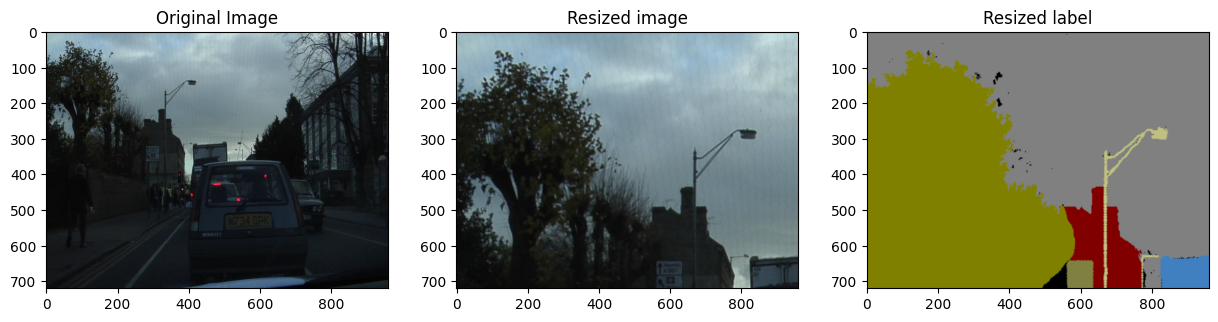

In [ ]:
resizer = T.Resize((720, 960))

resized = TF.crop(X_train_tensor[0].permute(2,0,1), 0, 0, 72*5, 96*5)
resized = resizer(resized)
resized = resized.permute(1,2,0)

resized_y = TF.crop(y_train_tensor[0].permute(2,0,1), 0, 0, 72*5, 96*5)
resized_y = resizer(resized_y)
resized_y = resized_y.permute(1,2,0)

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_title("Original Image")
ax1.imshow(X_train[img_idx])

ax2.set_title("Resized image")
ax2.imshow(resized.numpy())

ax3.set_title("Resized label")
ax3.imshow(resized_y.numpy())


plt.show()


In [ ]:
# combine y_train_tensor and X_train_tensor_along a new dimension



Training process:
1. calc loss
2. calc gradient
3. update weights
4. repeat